<a href="https://colab.research.google.com/github/AnasAito/Statisitcs-project-Emines/blob/main/Exploration_of_the_data_set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import norm
import scipy.stats as st
import pymc3 as pm
import arviz as az

In [ ]:
stabilo=pd.read_table('./stabilo.xlsx',sep=";",header=0)

In [ ]:
fig = px.histogram(stabilo, x="weight")
fig.show()

In [ ]:
fig = px.histogram(stabilo, x="height")
fig.show()

In [ ]:
fig = px.histogram(stabilo, x="age")
fig.show()

In [ ]:
!pip install arviz==0.6.1
!pip install pymc3==3.8
!pip install Theano==1.0.4

In [ ]:
def get_best_distribution(data):
    dist_names = ["chi2", "norm", "expon", "t", "gamma", "uniform"]
    # dist_names = ["norm"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        print(params[dist_name])
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

In [ ]:
col = "weight"
data=stabilo.copy()
get_best_distribution(data[col])

(36.78657191135311, 3.246682571228849, 1.8141977773459939)
p value for chi2 = 0.8934001743351276
(69.9848, 15.539582843821773)
p value for norm = 0.603861288883926
(32.82, 37.16480000000001)
p value for expon = 1.079280796638288e-08
(1575857.2038209406, 69.9851182322283, 15.53946333489369)
p value for t = 0.6036990419464664
(18.393290834913646, 3.246687677559086, 3.6283944119806195)
p value for gamma = 0.8934003069866652
(32.82, 81.63)
p value for uniform = 0.00011323052936786753
Best fitting distribution: gamma
Best p value: 0.8934003069866652
Parameters for the best fit: (18.393290834913646, 3.246687677559086, 3.6283944119806195)


('gamma',
 0.8934003069866652,
 (18.393290834913646, 3.246687677559086, 3.6283944119806195))

In [ ]:
paramName = 'Alpha'
with pm.Model() as model:
    # define the prior
    df = pm.Uniform(paramName, lower=15, upper=25)

    loc = 3.246687677559086
    scale = 3.6283944119806195

    # define the likelihood
    #data = (pm.Gamma('data', alpha=df, observed=data[col]) - loc) / scale
    data = pm.Gamma('data',alpha=df, beta=1/scale, observed=data[col]) - loc
    #data =pm.Normal('data',mu=df, sd=9.155735907069404,observed=data[col])
    #data = pm.Bernoulli('data', p=df, observed=data[col])
    # get the samples
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:00<00:00, 1943.27it/s]
The acceptance probability does not match the target. It is 0.8811064029417031, but should be close to 0.8. Try to increase the number of tuning steps.


0.4165841909588776


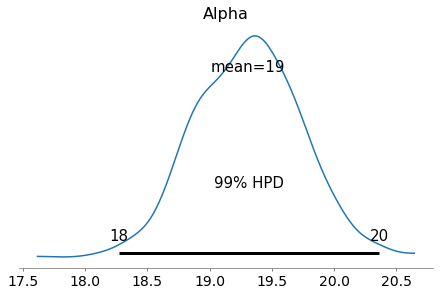

In [ ]:
with model:
    pm.plot_posterior(trace, credible_interval=0.99)

print(np.std(trace.get_values(paramName)))

In [ ]:
fig = go.Figure([go.Bar(x=['No_drugs','Dopamine','Anti-epilleptique','Anti-depresseur','Hypotenseur'], y=[57,3, 11,14,31])])
fig.update_layout(yaxis=dict(title='drugs'),title_text='Drugs taken by patients',xaxis=dict(title='count'))
fig.show()

In [ ]:
fig = go.Figure([go.Bar(x=['Aucun','Proprioceptif','Dysexecutif','Visuel','Auditif','Epicritique','Genou','Pied','Hanche','Cheville','Vestibulaire','Retropulsion','Rachis','Thermoalgique'], y=[23,32,23,7,6,4,3,4,2,2,2,1,1,1])])
fig.update_layout(yaxis=dict(title='diagnostics'),title_text='Diagnostics of patients',xaxis=dict(title='count'))
fig.show()

In [ ]:
fig = px.histogram(stabilo, x="total_fall_count")
fig.show()

In [ ]:
stabilo['is_fall'] = 1*(stabilo['total_fall_count']>0)
val_counts = stabilo["is_fall"].map({0:"is not falling",1:"is falling"}).value_counts()
fig = go.Figure(data=[go.Pie(labels=val_counts.index, values=val_counts.values)])
fig.update_layout(title_text='Falling rate in eldery')
fig.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:00<00:00, 2005.94it/s]


0.04447436641504379


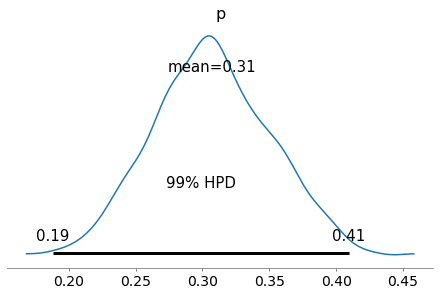

In [ ]:
col = "is_fall"
paramName = 'p'
with pm.Model() as model:
    # define the prior
    df = pm.Uniform(paramName, lower=0.1, upper=0.95)

    loc = 3.246687677559086
    scale = 3.6283944119806195

    # define the likelihood
    #data = (pm.Gamma('data', alpha=df, observed=data[col]) - loc) / scale
    #data = pm.Gamma('data',alpha=df, beta=1/scale, observed=data[col]) - loc
    #data =pm.Normal('data',mu=df, sd=9.155735907069404,observed=data[col])
    data = pm.Bernoulli('data', p=df, observed=stabilo[col])
    # get the samples
    trace = pm.sample()
    with model:
      pm.plot_posterior(trace, credible_interval=0.99)

print(np.std(trace.get_values(paramName)))